data source:

    https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?select=ratings_small.csv
    https://www.kaggle.com/datasets/asaniczka/tmdb-movies-dataset-2023-930k-movies?resource=download&select=TMDB_movie_dataset_v11.csv

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt 
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

### TMDB dataset

In [11]:
TMDB_movie = pd.read_csv("../data/TMDB_movie_dataset_v11.csv").dropna(subset=["popularity", "genres", "id"])
TMDB_rating = pd.read_csv("../data/ratings_small.csv").dropna(subset=["userId", "movieId", "rating", "timestamp"])
TMDB_rating.columns = ["userId", "id", "rating", "timestamp"]

merged_df = pd.merge(TMDB_movie, TMDB_rating, on="id", how="inner")
dataset = merged_df[["userId", "id", "rating", "timestamp", "popularity", "genres"]]

In [12]:
dataset = dataset.loc[dataset['genres'].notna()]
dataset_scaled = dataset.copy()
dataset_scaled["popularity"] /= (dataset["popularity"].max() - dataset["popularity"].min())

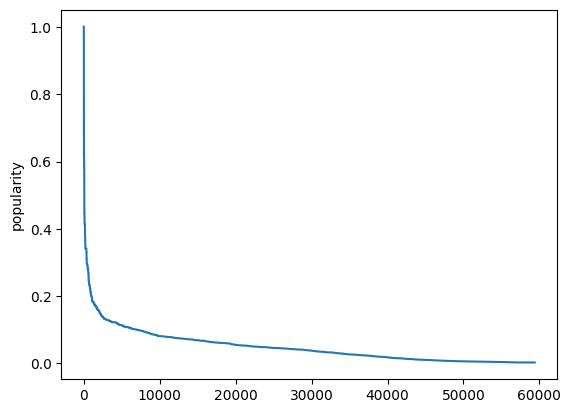

In [13]:
dataset_sorted = dataset_scaled.sort_values(by="popularity", ascending=False)

range_i = list(range(0, dataset_sorted.shape[0]))
sns.lineplot(x=range_i, y=dataset_sorted["popularity"])
plt.show()

Multilabel Encoder

In [14]:
genre_l = dataset_scaled['genres'].apply(lambda x :[ y.strip().lower().replace(' ','') for y in x.split(',')] )
genre_l

MLB = MultiLabelBinarizer()

encoded = MLB.fit_transform(genre_l)

dataset_preprocessed = pd.concat([dataset_scaled, pd.DataFrame(encoded, columns=MLB.classes_)], axis=1).drop(columns=["genres"])

In [17]:
dataset_preprocessed = dataset_preprocessed.sort_values(by="timestamp")
dataset_preprocessed["userId"] = dataset_preprocessed["userId"].astype(int)
dataset_preprocessed["id"] = dataset_preprocessed["id"].astype(int)


In [23]:
dataset_preprocessed.head(5)

,userId,id,rating,timestamp,popularity,action,adventure,animation,comedy,crime,...,history,horror,music,mystery,romance,sciencefiction,thriller,tvmovie,war,western
35596,383,21,3.0,789652009,0.028780,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10573,409,25,4.0,828212412,0.087790,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3520,409,35,4.0,828212412,0.198965,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1813,409,85,5.0,828212412,0.202450,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13941,409,16,4.0,828212412,0.060196,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


Data preparing

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

columns_remove = ['userId','rating', 'timestamp', 'popularity','genres']
columns_target = ["popularity"]
#user_150 = dataset[dataset['userId']==1]

X = dataset.drop(columns_remove, axis=1).values
y = dataset['popularity'].values

In [6]:
X_tensor = torch.tensor(X, dtype=torch.float32).view(-1, 5, 4)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

### LSTM

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])  # Get the output from the last time step
        return out

In [ ]:
model = LSTMModel(input_size=X.shape[1], hidden_size=64, output_size=1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Training loop
epochs = 50
for epoch in range(epochs):
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs.unsqueeze(1))  # Add a time step dimension
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}, Loss: {loss.item()}')



In [ ]:
model.eval()
with torch.no_grad():
    test_outputs = model(X_tensor.unsqueeze(1))  # Add a time step dimension
    print(test_outputs)   

### CNN

In [7]:
import torch
import torch.nn as nn

X_tensor = torch.tensor(X, dtype=torch.float32).view(-1, 5, 4)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=5, out_channels=16, kernel_size=3)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16, 64)  
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x=self.relu(x)
        return x

# Instantiate the model
model = CNNModel()
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
model.state_dict()['conv1.weight'].flatten().tolist()

[-0.03678722679615021,
 -0.21043390035629272,
 -0.24307739734649658,
 -0.1445058286190033,
 0.11992589384317398,
 -0.14495788514614105,
 0.00877449382096529,
 0.08450651168823242,
 -0.13473887741565704,
 0.21349367499351501,
 -0.18500860035419464,
 0.1632033884525299,
 0.14454956352710724,
 -0.2090136557817459,
 -0.15094681084156036,
 0.12587572634220123,
 0.0038669160567224026,
 -0.00508859334513545,
 0.21823227405548096,
 -0.03020908124744892,
 0.06211255490779877,
 0.03352119401097298,
 0.1110948845744133,
 0.14601963758468628,
 -0.0029424475505948067,
 0.21727637946605682,
 -0.027779854834079742,
 -0.21609237790107727,
 -0.13598354160785675,
 -0.23977692425251007,
 -0.14513526856899261,
 -0.03876359388232231,
 -0.044036462903022766,
 -0.2022310346364975,
 -0.22766049206256866,
 0.11316891759634018,
 0.19006413221359253,
 0.0292626041918993,
 0.2219301462173462,
 0.0922548770904541,
 0.13578538596630096,
 0.13671092689037323,
 -0.13222914934158325,
 -0.003796830540522933,
 0.1264055

In [8]:
epochs = 50
for epoch in range(epochs):
    for inputs, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Epoch 1, Loss: 11.943387031555176
Epoch 2, Loss: 14.499452590942383
Epoch 3, Loss: 14.973130226135254
Epoch 4, Loss: 12.265000343322754
Epoch 5, Loss: 10.385112762451172
Epoch 6, Loss: 17.040306091308594
Epoch 7, Loss: 15.615387916564941
Epoch 8, Loss: 12.970855712890625
Epoch 9, Loss: 15.05125904083252
Epoch 10, Loss: 17.068418502807617
Epoch 11, Loss: 14.275951385498047
Epoch 12, Loss: 13.603226661682129
Epoch 13, Loss: 14.661144256591797
Epoch 14, Loss: 16.3986759185791
Epoch 15, Loss: 15.893856048583984
Epoch 16, Loss: 12.566644668579102
Epoch 17, Loss: 15.27790355682373
Epoch 18, Loss: 13.969049453735352
Epoch 19, Loss: 13.707160949707031
Epoch 20, Loss: 14.016097068786621
Epoch 21, Loss: 12.657710075378418
Epoch 22, Loss: 15.435323715209961
Epoch 23, Loss: 16.511064529418945
Epoch 24, Loss: 15.668145179748535
Epoch 25, Loss: 11.789725303649902
Epoch 26, Loss: 12.905048370361328
Epoch 27, Loss: 15.481194496154785
Epoch 28, Loss: 15.294709205627441
Epoch 29, Loss: 17.89690208435058

In [9]:
model.eval()
with torch.no_grad():
    test_outputs = model(X_tensor)  # Add a time step dimension
    print(test_outputs)   

tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]])
